# Crime × Weather × Demographics ETL Pipeline (PySpark + Apache Sedona)

## Project Overview

This notebook implements a comprehensive ETL (Extract, Transform, Load) pipeline that integrates multiple data sources to create a unified dataset for analyzing crime patterns in relation to weather conditions and demographic characteristics. The pipeline processes large-scale crime data, weather records, and U.S. Census Bureau American Community Survey (ACS) demographics, then performs spatial joins to map crimes to census tracts using Apache Sedona for geospatial operations.

## Key Objectives

1. **Data Integration**: Combine crime incidents, weather data, and demographic information into a single denormalized dataset
2. **Spatial Analysis**: Map crime locations to census tracts using geospatial operations
3. **Scalability**: Handle large datasets (8+ million crime records) efficiently using PySpark
4. **Data Quality**: Ensure proper data cleaning, validation, and integration success tracking

## Data Sources

- **Crime Data**: `MyDrive/Data/CrimeDataFull.csv` - Contains crime incident records with location, type, date, and other attributes
- **Weather Data**: `MyDrive/Data/weather.csv` - Daily weather observations including precipitation, temperature, and snowfall
- **ACS Demographics**:
  - Median Income: `MyDrive/Data/Median_Income/` (multiple CSV files)
  - Population: `MyDrive/Data/Population_Data/` (multiple CSV files)
- **Census Tract Boundaries**: `MyDrive/Data/Census_Tracts/` - TIGER/Line shapefiles containing census tract geometries
- **Output Directory**: `MyDrive/Data/output/` - Stores processed Parquet files and analysis results

## Technology Stack

- **PySpark 3.5.1**: Distributed data processing framework
- **Apache Sedona 1.8.0**: Geospatial data processing library for Spark
- **Pandas/Matplotlib/Seaborn**: Data analysis and visualization
- **Folium/GeoPandas**: Interactive mapping and geospatial visualization

## Execution Instructions

Run cells sequentially from top to bottom in a fresh Colab runtime. Ensure Google Drive is mounted and all data files are accessible at the specified paths.

## Step 1: Environment Setup and Dependency Installation

This cell installs all required system packages and Python libraries needed for the ETL pipeline:

- **OpenJDK 11**: Required Java runtime for PySpark (Spark runs on the JVM)
- **PySpark 3.5.1**: Apache Spark Python API for distributed data processing
- **Apache Sedona 1.8.0**: Geospatial extension for Spark, enabling spatial operations
- **Pandas**: Data manipulation and analysis (used for visualization exports)
- **GeoPandas/Shapely/Fiona**: Geospatial data handling and shapefile reading
- **Matplotlib/Seaborn**: Statistical plotting and visualization
- **Folium**: Interactive map generation

The installation uses `--force-reinstall` to ensure clean dependencies and avoid version conflicts.


In [ ]:
# Install system dependencies
# Update package list and install OpenJDK 11 (required for PySpark)
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq

import sys

# Install Python packages required for the ETL pipeline
# - pyspark: Distributed data processing framework
# - findspark: Helper to locate Spark installation
# - pandas: Data manipulation for visualization exports
# - matplotlib/folium: Visualization libraries
# - apache-sedona: Geospatial processing extension for Spark
# - geopandas/shapely/fiona: Geospatial data handling
# - pyproj/rtree: Spatial reference systems and spatial indexing
%pip install -q pyspark==3.5.1 pandas findspark matplotlib folium apache-sedona==1.8.0 --upgrade --force-reinstall geopandas shapely fiona pyproj rtree

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible

## Step 2: Google Drive Mount and Data Path Configuration

Mounts Google Drive to access data files stored in the cloud. This cell also defines all file paths used throughout the pipeline:

- **Input Paths**: Locations of crime data, weather data, ACS demographics, and census tract shapefiles
- **Output Paths**: Directory structure for saving processed Parquet files at different stages:
  - `crime_weather_parquet`: Crime data joined with weather
  - `crime_weather_demo_parquet`: Crime + weather + demographics (before spatial join)
  - `crime_weather_demo_spatial`: Final integrated dataset with spatial tract assignments

These paths can be modified if your data is stored in different locations.


In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

# Define base directory for all data files
BASE_DATA_DIR = "/content/drive/MyDrive"

# Input data file paths
CRIME_PATH = f"{BASE_DATA_DIR}/CrimeDataFull.csv"  # Crime incident records
WEATHER_PATH = f"{BASE_DATA_DIR}/weather.csv"  # Daily weather observations
ACS_INCOME_DIR = f"{BASE_DATA_DIR}/Median_Income"  # ACS median income CSV files
ACS_POP_DIR = f"{BASE_DATA_DIR}/Population_Data"  # ACS population CSV files
TRACT_SHAPEFILE_DIR = f"{BASE_DATA_DIR}/Census_Tracts"  # TIGER/Line shapefiles (.shp, .dbf, .shx, etc.)

# Output paths for processed Parquet files (staged outputs)
OUTPUT_PARQUET = f"{BASE_DATA_DIR}/output/crime_weather_parquet"  # Crime + Weather join
OUTPUT_DEMO_PARQUET = f"{BASE_DATA_DIR}/output/crime_weather_demo_parquet"  # + Demographics
OUTPUT_DEMO_SPATIAL = f"{BASE_DATA_DIR}/output/crime_weather_demo_spatial"  # Final with spatial tracts

Mounted at /content/drive


## Step 3: Spark and Apache Sedona Configuration

This cell initializes the Spark session with Apache Sedona for geospatial processing. Key configurations include:

- **Java Environment**: Sets JAVA_HOME to the installed OpenJDK location
- **Sedona Integration**: Loads Sedona JARs compatible with Spark 3.5 and Scala 2.12
- **Kryo Serialization**: Optimizes serialization for better performance with spatial data
- **Memory Configuration**: Allocates sufficient driver memory (8GB) for large dataset processing
- **Shuffle Partitions**: Configures 200 partitions for distributed operations
- **Legacy Time Parser**: Enables parsing of older date formats in the crime data

The SedonaContext provides spatial functions like `ST_Point`, `ST_Contains`, and shapefile reading capabilities.

In [ ]:
# Configure Java environment for Spark
import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
findspark.init()  # Initialize findspark to locate Spark installation

from pyspark.sql import SparkSession
from sedona.spark import SedonaContext

# Define Sedona Maven packages for Spark 3.5, Scala 2.12, Sedona 1.8.0
# These JARs provide geospatial functions and shapefile reading capabilities
packages = ",".join([
    "org.apache.sedona:sedona-spark-shaded-3.5_2.12:1.8.0",  # Main Sedona library
    "org.apache.sedona:sedona-common:1.8.0"  # Common utilities
])

# Build Spark session with optimized configurations
spark = SparkSession.builder \
    .appName("CrimeWeatherDemographicsSpatialETL") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "org.apache.sedona.core.serde.SedonaKryoRegistrator") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.jars.packages", packages) \
    .getOrCreate()

# Create SedonaContext for spatial operations (new API)
# This enables functions like ST_Point, ST_Contains, and shapefile reading
sedona = SedonaContext.create(spark)

# Enable legacy time parser to handle older date formats in crime data
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
print("Spark:", spark.version)

Spark: 3.5.1


## Step 4: Load Raw Crime and Weather Data

This cell reads the initial crime and weather datasets from CSV files. Key optimizations:

- **Explicit Schema Definition**: Defines the complete crime data schema upfront to avoid schema inference overhead
- **Selective Column Loading**: Only loads essential columns (ID, Date, Primary Type, Arrest, Domestic, Latitude, Longitude) to reduce memory usage
- **Schema Enforcement**: Uses the defined schema to ensure data type consistency and catch errors early
- **Weather Data**: Reads weather CSV with header detection for flexible column names

This selective loading approach is critical for handling large datasets (8+ million records) efficiently.

In [ ]:
# Define explicit schema for crime data to avoid schema inference overhead
from pyspark.sql.types import *
from pyspark.sql.functions import col

# Complete schema definition for crime CSV (all columns)
# Using explicit types ensures data consistency and faster parsing
crime_schema = StructType([
    StructField("ID", LongType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", StringType(), True),
    StructField("Community Area", StringType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", StringType(), True),
    StructField("Y Coordinate", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True),
])

# Memory optimization: Load only essential columns needed for analysis
# This reduces memory footprint significantly for 8+ million records
cols_to_keep = ["ID", "Date", "Primary Type", "Arrest", "Domestic", "Latitude", "Longitude"]

# Read crime CSV with schema enforcement and select only needed columns
crime_df = spark.read.csv(CRIME_PATH, header=True, schema=crime_schema, ignoreLeadingWhiteSpace=True)\
    .select(*cols_to_keep)

# Read weather data (header detection enabled for flexible column names)
weather_raw = spark.read.option("header", True).csv(WEATHER_PATH)

# Verify data loading
print(f"Crime rows loaded (Optimized): {crime_df.count()}")
crime_df.show(3)

Crime rows loaded (Optimized): 8438990
+--------+--------------------+--------------------+------+--------+------------+------------+
|      ID|                Date|        Primary Type|Arrest|Domestic|    Latitude|   Longitude|
+--------+--------------------+--------------------+------+--------+------------+------------+
|13311263|07/29/2022 03:39:...|OFFENSE INVOLVING...|  true|   false|        NULL|        NULL|
|13053066|01/03/2023 04:44:...|           NARCOTICS|  true|   false|        NULL|        NULL|
|12131221|08/10/2020 09:45:...|             ROBBERY|  true|   false|41.908417822|-87.67740693|
+--------+--------------------+--------------------+------+--------+------------+------------+
only showing top 3 rows



## Step 5: Crime Data Transformation and Feature Engineering

This cell performs comprehensive data cleaning and feature extraction on the crime dataset:

- **Timestamp Parsing**: Converts date strings to proper timestamp and date types
- **Temporal Features**: Extracts year, month, hour, and weekday for time-based analysis
- **Boolean Normalization**: Standardizes Arrest and Domestic fields from various string formats (TRUE/True/true/1/t) to boolean values
- **Deduplication**: Removes duplicate records based on crime ID
- **Column Renaming**: Standardizes column names (e.g., "Primary Type" → "primary_type") for consistency

These derived features enable temporal analysis of crime patterns (hourly, daily, seasonal trends).

In [ ]:
# Crime data transformation and feature engineering
from pyspark.sql.functions import to_timestamp, to_date, trim, when, date_format, hour, dayofweek, month, col

# Step 1: Rename columns and derive temporal features
# Standardize column name and parse date/timestamp fields
crime = crime_df.withColumnRenamed("Primary Type", "primary_type") \
    .withColumn("crime_ts", to_timestamp(col("Date"), "MM/dd/yyyy hh:mm:ss a")) \
    .withColumn("crime_date", to_date(col("crime_ts"))) \
    .withColumn("year", date_format(col("crime_date"), "yyyy").cast("int")) \
    .withColumn("month", month(col("crime_date"))) \
    .withColumn("hour", hour(col("crime_ts"))) \
    .withColumn("weekday", dayofweek(col("crime_date"))) \
    .dropDuplicates(["ID"])  # Remove duplicate crime records

# Step 2: Normalize boolean columns (Arrest and Domestic)
# Handle various string formats: "TRUE", "True", "true", "1", "t" → boolean
# Case-insensitive regex matching with trimming for robustness
crime = crime.withColumn("arrest", when(trim(col("Arrest")).rlike("(?i)^(true|t|1)$"), True).otherwise(False)) \
             .withColumn("domestic", when(trim(col("Domestic")).rlike("(?i)^(true|t|1)$"), True).otherwise(False))

# Step 3: Display sample of transformed data for verification
crime.select("ID", "crime_date", "primary_type", "arrest", "domestic", "hour", "weekday").show(5, truncate=False)
print("Crime rows processed:", crime.count())

+---+----------+------------+------+--------+----+-------+
|ID |crime_date|primary_type|arrest|domestic|hour|weekday|
+---+----------+------------+------+--------+----+-------+
|635|2001-01-01|HOMICIDE    |false |false   |15  |2      |
|638|2001-01-05|HOMICIDE    |false |false   |16  |6      |
|650|2001-01-11|HOMICIDE    |true  |true    |18  |5      |
|656|2001-01-14|HOMICIDE    |true  |false   |14  |1      |
|662|2001-01-19|HOMICIDE    |true  |false   |1   |6      |
+---+----------+------------+------+--------+----+-------+
only showing top 5 rows

Crime rows processed: 8438990


## Step 6: Weather Data Processing and Join with Crime Data

This cell processes weather data and joins it with crime records:

- **Date Column Detection**: Automatically identifies the date column using heuristics (searches for "date", "day", "observation_date", "datetime")
- **Robust Date Parsing**: Handles multiple date formats (yyyy-MM-dd, dd/MM/yy, MM/dd/yyyy) with fallback logic
- **Numeric Column Casting**: Converts weather metrics (PRCP, SNOW, TMAX, TMIN) to double precision
- **Daily Aggregation**: Aggregates weather metrics by date (handles multiple observations per day)
- **Broadcast Join Optimization**: Uses broadcast join since weather data is small (~8K rows) compared to crime data (8M+ rows), avoiding expensive shuffles
- **Caching**: Caches the small weather dataset to prevent re-reading from CSV

The left join ensures all crime records are preserved, with NULL weather values for dates without weather data.

In [ ]:
# Weather data processing and join with crime data
from pyspark.sql.functions import to_date, regexp_replace, col, avg, broadcast, when

# Step 1: Automatically identify date column using heuristic search
# Searches for common date column names (case-insensitive)
possible_date_cols = [c for c in weather_raw.columns if c.lower() in ("date","day","observation_date","datetime")]
WEATHER_DATE_COL = possible_date_cols[0] if possible_date_cols else "DATE"
print(f"Using weather date column: {WEATHER_DATE_COL}")

# Step 2: Clean and parse date column
# Remove BOM (Byte Order Mark) characters that can appear in CSV files
weather = weather_raw.withColumn(WEATHER_DATE_COL, regexp_replace(col(WEATHER_DATE_COL), r'^\ufeff', ''))
# Try standard ISO date format first
weather = weather.withColumn("weather_date", to_date(col(WEATHER_DATE_COL), "yyyy-MM-dd"))

# Fallback date parsing for alternative formats
# Handles common variations: dd/MM/yy, MM/dd/yyyy, MM/dd/yy
weather = weather.withColumn("weather_date",
    when(weather.weather_date.isNull(), to_date(col(WEATHER_DATE_COL), "dd/MM/yy"))
    .when(weather.weather_date.isNull(), to_date(col(WEATHER_DATE_COL), "MM/dd/yyyy"))
    .when(weather.weather_date.isNull(), to_date(col(WEATHER_DATE_COL), "MM/dd/yy"))
    .otherwise(weather.weather_date)
)

# Step 3: Cast numeric weather columns to double precision
# Standard NOAA weather columns: PRCP (precipitation), SNOW, TMAX (max temp), TMIN (min temp)
target_metrics = ["PRCP", "SNOW", "TMAX", "TMIN"]
numeric_candidates = [c for c in weather.columns if c in target_metrics or c in ["precip", "snowfall", "temp"]]

for c in numeric_candidates:
    weather = weather.withColumn(c, col(c).cast("double"))

# Step 4: Aggregate weather metrics by day (average for multiple observations per day)
agg_cols = [avg(col(c)).alias(f"{c}_avg") for c in numeric_candidates]
weather_daily = weather.groupBy("weather_date").agg(*agg_cols).orderBy("weather_date")

# Performance optimization: Cache small weather dataset to avoid re-reading from CSV
weather_daily.cache()
print(f"Weather distinct days: {weather_daily.count()}")
weather_daily.show(5, truncate=False)

# Step 5: Join weather data to crime data using broadcast join
# Broadcast join optimization: weather table is small (~8K rows) vs crime (8M+ rows)
# Broadcasting sends weather table to all nodes, avoiding expensive shuffle of crime data
final = crime.join(
    broadcast(weather_daily),
    crime.crime_date == weather_daily.weather_date,
    how="left"  # Left join preserves all crime records
).drop("weather_date")  # Remove redundant date column

print("Final rows after weather join (Lazy execution):")
final.printSchema()

Using weather date column: DATE
Weather distinct days: 8766
+------------+--------+--------+--------+--------+
|weather_date|PRCP_avg|SNOW_avg|TMAX_avg|TMIN_avg|
+------------+--------+--------+--------+--------+
|2001-01-01  |0.0     |0.0     |-4.4    |-15.0   |
|2001-01-02  |0.0     |0.0     |-7.2    |-15.0   |
|2001-01-03  |0.0     |0.0     |-2.2    |-13.9   |
|2001-01-04  |0.0     |0.0     |-1.1    |-7.2    |
|2001-01-05  |0.0     |0.0     |2.2     |-6.1    |
+------------+--------+--------+--------+--------+
only showing top 5 rows

Final rows after weather join (Lazy execution):
root
 |-- ID: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- arrest: boolean (nullable = false)
 |-- domestic: boolean (nullable = false)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- crime_ts: timestamp (nullable = true)
 |-- crime_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- mon

## Step 7: Load and Process ACS Demographics Data

This cell reads American Community Survey (ACS) demographic data from multiple CSV files:

- **Folder Reading**: Scans directories for all CSV files ending in "Data.csv"
- **Data Filtering**: Removes header rows (where GEO_ID = "Geography")
- **Year Extraction**: Extracts survey year from filename using regex pattern matching
- **Column Selection**: Extracts GEO_ID (census tract identifier), NAME, and estimate columns:
  - `B19013_001E`: Median household income estimate
  - `B01003_001E`: Total population estimate
- **Union Operation**: Combines multiple ACS files (different years) into single DataFrames
- **Join Operation**: Inner joins income and population data on source_file (year) to create combined demographics dataset

The ACS data provides socioeconomic context for each census tract, enabling demographic analysis of crime patterns.

In [ ]:
# Read and process ACS (American Community Survey) demographics data
import os, re
from pyspark.sql.functions import col, lit

def read_acs_folder(folder_path, estimate_col, label):
    """
    Reads all ACS CSV files from a folder and combines them.

    Args:
        folder_path: Directory containing ACS CSV files
        estimate_col: Column name containing the estimate value (e.g., "B19013_001E")
        label: New name for the estimate column

    Returns:
        Unioned DataFrame with GEO_ID, NAME, estimate, source_file, and acs_year
    """
    # Find all CSV files ending with "Data.csv"
    files = []
    for f in os.listdir(folder_path):
        if f.endswith("Data.csv"):
            files.append(os.path.join(folder_path, f))

    dfs = []
    for f in files:
        # Read CSV with header
        df = spark.read.option("header", True).csv(f)
        # Filter out header rows (where GEO_ID = "Geography")
        df = df.filter(df.GEO_ID != "Geography")

        # Validate required columns exist
        if estimate_col in df.columns and "GEO_ID" in df.columns:
            # Extract year from filename (e.g., "ACSDT5Y2022" -> "2022")
            base_name = os.path.basename(f).split(".")[0]
            year_match = re.search(r"\d{4}", base_name)
            year_val = year_match.group(0) if year_match else None

            # Select and rename columns, add metadata
            df = df.select("GEO_ID", "NAME", estimate_col)\
                .withColumnRenamed(estimate_col, label)\
                .withColumn("source_file", lit(base_name))\
                .withColumn("acs_year", lit(year_val))
            dfs.append(df)

    if not dfs:
        return None

    # Union all DataFrames from different years
    union_df = dfs[0]
    for d in dfs[1:]:
        union_df = union_df.unionByName(d)
    return union_df

# Read median income data (B19013_001E is the ACS table code for median household income)
income_df = read_acs_folder(ACS_INCOME_DIR, "B19013_001E", "Median_Income")

# Read population data (B01003_001E is the ACS table code for total population)
pop_df = read_acs_folder(ACS_POP_DIR, "B01003_001E", "Population_Data")

# Drop redundant columns from income (will join on source_file)
income_df = income_df.drop("GEO_ID","NAME")

# Display sample data
income_df.show(5, truncate=False)
pop_df.show(5, truncate=False)
print("Income rows:", income_df.count() if income_df else 0)
print("Population rows:", pop_df.count() if pop_df else 0)

# Join income and population data on source_file (year identifier)
acs_df = income_df.join(pop_df, "source_file", "inner") if (income_df and pop_df) else None
acs_df.show(5, truncate=False)
print("ACS combined rows:", acs_df.count())

+-------------+-----------+--------+
|Median_Income|source_file|acs_year|
+-------------+-----------+--------+
|78538        |ACSDT5Y2023|2023    |
|69021        |ACSDT5Y2021|2021    |
|75149        |ACSDT5Y2022|2022    |
|62843        |ACSDT5Y2019|2019    |
|64994        |ACSDT5Y2020|2020    |
+-------------+-----------+--------+
only showing top 5 rows

+--------------------+------------------------------------------+---------------+-----------+--------+
|GEO_ID              |NAME                                      |Population_Data|source_file|acs_year|
+--------------------+------------------------------------------+---------------+-----------+--------+
|1400000US17031010100|Census Tract 101; Cook County; Illinois   |4284           |ACSDT5Y2022|2022    |
|1400000US17031010201|Census Tract 102.01; Cook County; Illinois|8210           |ACSDT5Y2022|2022    |
|1400000US17031010202|Census Tract 102.02; Cook County; Illinois|2865           |ACSDT5Y2022|2022    |
|1400000US17031010300|Ce

## Step 8: Spatial Join - Map Crimes to Census Tracts

This cell performs the critical spatial operation that maps crime locations to census tracts:

- **Shapefile Loading**: Reads TIGER/Line census tract shapefiles using Sedona's shapefile reader
- **GEOID Standardization**: Handles different GEOID column names (GEOID, GEOID10) or constructs from components (STATEFP + COUNTYFP + TRACTCE)
- **Point Geometry Creation**: Converts crime latitude/longitude coordinates to Sedona point geometries using `ST_Point`
- **Spatial Containment Join**: Uses `ST_Contains` to determine which census tract polygon contains each crime point
- **Broadcast Join Optimization**: Broadcasts the small tracts table to all nodes for efficient spatial join
- **Checkpointing Strategy**: Writes intermediate results to disk to prevent memory overflow and DAG complexity issues with large datasets

**Important**: This is the most computationally expensive operation. The checkpointing step writes to disk to free memory before the final demographic join.

In [ ]:
# Spatial join: Map crime locations to census tracts using Apache Sedona
import time
start_time = time.time()
from pyspark.sql.functions import expr, col, broadcast

# Step 1: Load census tract shapefiles and standardize GEOID
# Sedona can read shapefiles directly using the shapefile format
tracts_df = sedona.read.format("shapefile").load(TRACT_SHAPEFILE_DIR)
tracts_df = tracts_df.withColumnRenamed("geometry", "tract_geom")  # Rename for clarity

# Standardize tract identifier (GEOID) - handle different shapefile formats
cols = tracts_df.columns
if "GEOID" in cols:
    # Standard GEOID column (11-digit code: STATE+COUNTY+TRACT)
    tracts_df = tracts_df.withColumn("tract_id", col("GEOID"))
elif "GEOID10" in cols:
    # Alternative GEOID column name (2010 Census format)
    tracts_df = tracts_df.withColumn("tract_id", col("GEOID10"))
else:
    # Construct GEOID from component fields if not present
    from pyspark.sql.functions import concat_ws
    tracts_df = tracts_df.withColumn("tract_id", concat_ws('', col("STATEFP"), col("COUNTYFP"), col("TRACTCE")))

# Memory optimization: Select only geometry and ID columns for spatial join
# This reduces memory footprint during the expensive spatial operation
tracts_light = tracts_df.select("tract_geom", "tract_id")
tracts_light.cache()  # Cache small tracts table for reuse
print(f"Tracts cached. Count: {tracts_light.count()}")

# Step 2: Create point geometries from crime coordinates
# Filter out records with missing coordinates and create Sedona point geometries
# Note: ST_Point takes (longitude, latitude) - order matters!
crime_points = final.filter(col("Latitude").isNotNull() & col("Longitude").isNotNull()) \
    .withColumn("crime_point", expr("ST_Point(Longitude, Latitude)"))

# Step 3: Perform spatial containment join
# ST_Contains checks if tract polygon contains crime point
# Broadcast join: tracts table is small, so broadcast to all nodes for efficiency
crime_with_tract = crime_points.join(
    broadcast(tracts_light),
    expr("ST_Contains(tract_geom, crime_point)"),  # Spatial predicate
    "left"  # Left join preserves all crime records
)

# Clean up: rename tract_id and drop geometry columns (no longer needed)
crime_with_tract = crime_with_tract.withColumnRenamed("tract_id", "tract_geoid").drop("tract_geom", "crime_point")

# Step 4: CRITICAL - Write intermediate result to disk (checkpointing)
# This prevents "DAG too big" errors and OOM (Out of Memory) issues
# By materializing the spatial join, we break the computation graph
INTERMEDIATE_PATH = f"{BASE_DATA_DIR}/output/intermediate_crime_spatial"
print("Writing intermediate spatial join to disk (this may take 5-10 mins but prevents crashing)...")

crime_with_tract.write.mode("overwrite").parquet(INTERMEDIATE_PATH)
print("Intermediate spatial data saved.")

# Step 5: Reload checkpointed data for next stage
# Reading from Parquet is faster and frees memory from previous operations
crime_with_tract_optimized = spark.read.parquet(INTERMEDIATE_PATH)
print(f"Reloaded full dataset. Count: {crime_with_tract_optimized.count()}")

# Performance metric
end_time = time.time()
print(f"Scalability Metric: Spatial Join & Checkpoint took {(end_time - start_time)/60:.2f} minutes.")

Tracts cached. Count: 3265
Writing intermediate spatial join to disk (this may take 5-10 mins but prevents crashing)...
Intermediate spatial data saved.
Reloaded full dataset. Count: 8344980
Scalability Metric: Spatial Join & Checkpoint took 5.93 minutes.


## Step 9: Join Demographics Data to Crime-Weather-Tract Dataset

This cell integrates ACS demographic data (median income and population) with the spatially-joined crime data:

- **GEOID Normalization**: Extracts the 11-digit census tract GEOID from ACS GEO_ID format
  - ACS format: `1400000US` + 11-digit GEOID (e.g., `1400000US17031010100`)
  - Extracted GEOID: `17031010100` (matches shapefile tract_geoid)
- **Aggregation**: Handles potential duplicates by averaging income and population values per tract
- **Left Join**: Preserves all crime records, with NULL demographics for tracts not in ACS data
- **Final Integration**: Creates the complete denormalized dataset with crime, weather, spatial tract, and demographic attributes

This completes the ETL pipeline, producing a wide table ready for analysis.

In [ ]:
# Join ACS demographics to crime-weather-tract dataset
from pyspark.sql.functions import regexp_extract, avg, col

# Validate ACS data was loaded successfully
if acs_df:
    # Rename population column for consistency
    acs_df = acs_df.withColumnRenamed("Population_Data", "population")

    # Step 1: Extract 11-digit GEOID from ACS GEO_ID format
    # ACS format: "1400000US17031010100" -> extract "17031010100"
    # Regex pattern: "US" followed by 11 digits
    acs_df_norm = acs_df.withColumn("tract_geoid", regexp_extract(col("GEO_ID"), r"US(\d{11})", 1))

    # Step 2: Aggregate demographics by tract (handle duplicates from multiple years)
    # Average income and population if same tract appears in multiple ACS files
    acs_df_norm = acs_df_norm.groupBy("tract_geoid").agg(
        avg("median_income").alias("median_income"),
        avg("population").alias("population")
    )

    # Step 3: Join demographics to checkpointed crime-weather-tract data
    # Left join preserves all crime records (NULL demographics for unmatched tracts)
    crime_demo = crime_with_tract_optimized.join(
        acs_df_norm,
        "tract_geoid",
        "left"
    )

    print("Final Integrated Data Created (Lazy).")
    crime_demo.printSchema()
else:
    print("ACS Data not loaded correctly in Cell 8.")

Final Integrated Data Created (Lazy).
root
 |-- tract_geoid: string (nullable = true)
 |-- ID: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- crime_ts: timestamp (nullable = true)
 |-- crime_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- PRCP_avg: double (nullable = true)
 |-- SNOW_avg: double (nullable = true)
 |-- TMAX_avg: double (nullable = true)
 |-- TMIN_avg: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- population: double (nullable = true)



## Step 10: Save Final Integrated Dataset

This cell persists the complete integrated dataset to disk:

- **Parquet Format**: Uses columnar Parquet format for efficient storage and querying
- **Partitioning**: Partitions by year for optimized time-range queries
- **Overwrite Mode**: Replaces existing output if present
- **Persistence Benefits**:
  - Avoids re-running expensive joins for subsequent analysis
  - Enables fast data access for visualization and reporting
  - Supports incremental updates by year

The saved dataset contains all integrated attributes: crime details, weather metrics, census tract identifiers, and demographic information.

In [ ]:
# Save final integrated dataset to Parquet format
# This persists the complete ETL pipeline output for future analysis
OUTPUT_DEMO_SPATIAL = f"{BASE_DATA_DIR}/output/crime_weather_demo_spatial"

# Write with year partitioning for efficient time-range queries
# Parquet format provides columnar storage, compression, and schema preservation
crime_demo.write.mode("overwrite").partitionBy("year").parquet(OUTPUT_DEMO_SPATIAL)
print(f"Saved final integrated dataset to: {OUTPUT_DEMO_SPATIAL}")

Saved final integrated dataset to: /content/drive/MyDrive/output/crime_weather_demo_spatial


## Step 11: Data Quality Validation and Pipeline Verification

This cell performs comprehensive validation checks on the integrated dataset:

- **Volume Validation**: Verifies total record count matches expectations
- **Integration Success Rates**: Calculates percentage of records successfully joined with:
  - Census tracts (spatial join success rate)
  - Demographics (ACS join success rate)
  - Weather data (weather join success rate)
- **Schema Validation**: Verifies all expected columns are present in the final dataset
- **Partition Verification**: Checks year partitioning for data distribution

These metrics help identify data quality issues and ensure the ETL pipeline completed successfully.

In [ ]:
# Data quality validation and pipeline verification
from pyspark.sql.functions import col, sum as Fsum, when

print("=== PIPELINE VALIDATION REPORT ===")

# Step 1: Volume validation - verify total record count
count_final = crime_demo.count()
print(f"Total Integrated Rows: {count_final}")

# Step 2: Calculate integration success rates
# Count null values for each join to determine match rates
missing_stats = crime_demo.agg(
    Fsum(when(col("tract_geoid").isNull(), 1).otherwise(0)).alias("missing_tract"),
    Fsum(when(col("median_income").isNull(), 1).otherwise(0)).alias("missing_income"),
    # Check weather join using last column (typically temperature)
    Fsum(when(col(crime_demo.columns[-1]).isNull(), 1).otherwise(0)).alias("missing_weather")
).collect()[0]

# Calculate percentage of successful joins
pct_tract_match = ((count_final - missing_stats["missing_tract"]) / count_final) * 100
pct_income_match = ((count_final - missing_stats["missing_income"]) / count_final) * 100
pct_weather_match = ((count_final - missing_stats["missing_weather"]) / count_final) * 100

print(f"\n--- Integration Quality ---")
print(f"Spatial Join Success (Tracts):   {pct_tract_match:.2f}%")
print(f"Demographic Join Success:        {pct_income_match:.2f}%")
print(f"Weather Join Success:            {pct_weather_match:.2f}%")

# Step 3: Schema validation - verify all expected columns exist
print(f"\n--- Schema Check ---")
# Case-insensitive comparison for robustness
actual_cols_lower = [c.lower() for c in crime_demo.columns]
expected_columns = ["id", "crime_date", "primary_type", "tract_geoid", "median_income", "population", "tmax_avg"]

missing_cols = [c for c in expected_columns if c not in actual_cols_lower]

if not missing_cols:
    print("✅ Schema Validation Passed: Table is wide and denormalized.")
else:
    print(f"❌ Schema Validation Failed. Missing: {missing_cols}")

# Step 4: Partition verification - check year distribution
print(f"\n--- Partitioning ---")
crime_demo.select("year").distinct().orderBy("year").show(5, False)
print("... (showing first 5 years only for brevity)")

=== PIPELINE VALIDATION REPORT ===
Total Integrated Rows: 8344980

--- Integration Quality ---
Spatial Join Success (Tracts):   100.00%
Demographic Join Success:        100.00%
Weather Join Success:            100.00%

--- Schema Check ---
✅ Schema Validation Passed: Table is wide and denormalized.

--- Partitioning ---
+----+
|year|
+----+
|2001|
|2002|
|2003|
|2004|
|2005|
+----+
only showing top 5 rows

... (showing first 5 years only for brevity)


## Step 12: Exploratory Data Analysis with Spark SQL

This cell demonstrates analytical queries on the integrated dataset using Spark SQL:

- **Top Crime Types**: Identifies most frequent crime types across all years
- **Yearly Trends**: Analyzes crime volume trends over time
- **Hourly Patterns**: Examines crime distribution by hour of day
- **Weather-Crime Relationships**: Explores correlations between temperature and crime types
- **Temporal Heatmaps**: Creates weekday-hour crime frequency matrices

The queries leverage the denormalized structure for efficient aggregations and provide insights into crime patterns, temporal trends, and potential weather influences.

In [ ]:
# Exploratory data analysis using Spark SQL
# Register DataFrame as a temporary SQL view for querying
crime_demo.createOrReplaceTempView("crime_weather_demo")

print("View 'crime_weather_demo' created successfully.")

# Define analytical queries for crime pattern exploration
queries = {
    "top_primary_types_all_time":
    """
    -- Identify most frequent crime types across entire dataset
    SELECT primary_type, COUNT(*) AS cnt
    FROM crime_weather_demo
    GROUP BY primary_type
    ORDER BY cnt DESC
    LIMIT 20
    """,
    "yearly_crime_trend":
    """
    -- Analyze crime volume trends over years
    SELECT year, COUNT(*) as cnt
    FROM crime_weather_demo
    GROUP BY year
    ORDER BY year
    """,
    "hourly_distribution_all_time":
    """
    -- Examine crime distribution by hour of day
    SELECT hour, COUNT(*) as cnt
    FROM crime_weather_demo
    GROUP BY hour
    ORDER BY hour
    """,
    "weather_influence_by_type":
    """
    -- Explore relationship between temperature and crime types
    SELECT primary_type, COUNT(*) as cnt,
           AVG(coalesce(tmax_avg, tmin_avg)) as avg_temp_metric
    FROM crime_weather_demo
    GROUP BY primary_type
    ORDER BY cnt DESC
    LIMIT 20
    """,
    "weekday_hour_heatmap_all_time":
    """
    -- Create temporal heatmap: crime frequency by weekday and hour
    SELECT weekday, hour, COUNT(*) as cnt
    FROM crime_weather_demo
    GROUP BY weekday, hour
    ORDER BY weekday, hour
    """
}

# Execute all queries with error handling
for name, q in queries.items():
    print(f"== Running Query: {name} ==")
    try:
        spark.sql(q).show(10, truncate=False)
    except Exception as e:
        print(f"Query '{name}' failed: {e}")

View 'crime_weather_demo' created successfully.
== Running Query: top_primary_types_all_time ==
+-------------------+-------+
|primary_type       |cnt    |
+-------------------+-------+
|THEFT              |1770279|
|BATTERY            |1530899|
|CRIMINAL DAMAGE    |954951 |
|NARCOTICS          |751303 |
|ASSAULT            |563292 |
|OTHER OFFENSE      |521655 |
|BURGLARY           |444343 |
|MOTOR VEHICLE THEFT|428418 |
|DECEPTIVE PRACTICE |367115 |
|ROBBERY            |313294 |
+-------------------+-------+
only showing top 10 rows

== Running Query: yearly_crime_trend ==
+----+------+
|year|cnt   |
+----+------+
|2001|482879|
|2002|471531|
|2003|472042|
|2004|467212|
|2005|449929|
|2006|445565|
|2007|435708|
|2008|419898|
|2009|385965|
|2010|369983|
+----+------+
only showing top 10 rows

== Running Query: hourly_distribution_all_time ==
+----+------+
|hour|cnt   |
+----+------+
|0   |474059|
|1   |266919|
|2   |226153|
|3   |184203|
|4   |140843|
|5   |118120|
|6   |135943|
|7   |

## Step 13: Time Series Visualization - Daily Crime Trends

This cell creates a time series visualization of daily crime incidents:

- **Daily Aggregation**: Groups crimes by date and counts incidents per day
- **CSV Export**: Saves daily counts to CSV for external analysis
- **Time Series Plot**: Creates a line chart showing crime trends over the entire time period (2001-present)
- **Visualization**: Uses matplotlib to display long-term patterns, seasonal variations, and anomalies

The visualization helps identify long-term trends, seasonal patterns, and potential data quality issues.


Running daily trend query (this may take 30-60 seconds)...
Saved: /content/drive/MyDrive/output/daily_incidents_all_time.csv


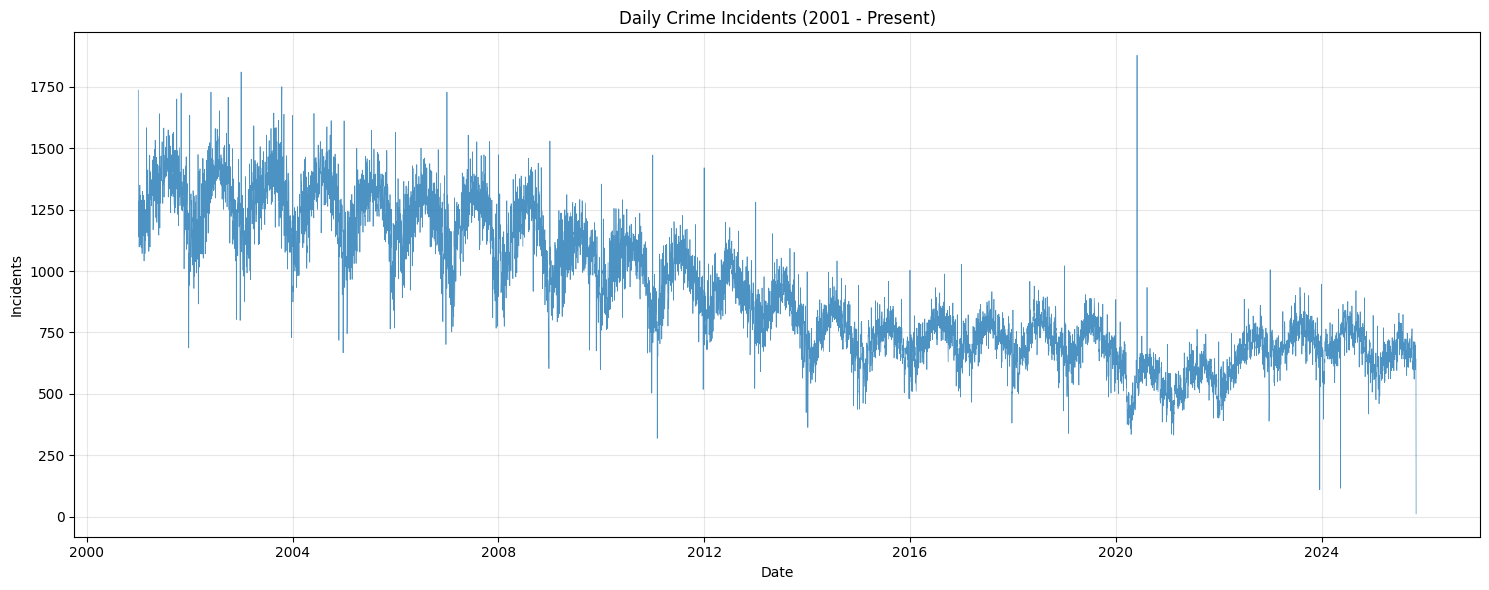

In [ ]:
# Export daily crime incidents and create time series visualization
import os
import pandas as pd
import matplotlib.pyplot as plt

# Query to aggregate crimes by date
daily_query = """
    SELECT crime_date, COUNT(*) as incidents
    FROM crime_weather_demo
    GROUP BY crime_date
    ORDER BY crime_date
"""

print("Running daily trend query (this may take 30-60 seconds)...")
# Convert Spark DataFrame to Pandas for visualization
daily_df = spark.sql(daily_query).toPandas()

# Export daily counts to CSV for external analysis
csv_out = f"{BASE_DATA_DIR}/output/daily_incidents_all_time.csv"
os.makedirs(os.path.dirname(csv_out), exist_ok=True)
daily_df.to_csv(csv_out, index=False)
print("Saved:", csv_out)

# Create time series visualization
if not daily_df.empty:
    # Convert date string to datetime for proper time series plotting
    daily_df['crime_date'] = pd.to_datetime(daily_df['crime_date'])

    # Create line plot with thin line for high-density data (~8000 days)
    plt.figure(figsize=(15, 6))
    plt.plot(daily_df['crime_date'], daily_df['incidents'], linewidth=0.5, alpha=0.8)

    plt.title('Daily Crime Incidents (2001 - Present)')
    plt.xlabel('Date')
    plt.ylabel('Incidents')
    plt.grid(True, alpha=0.3)  # Subtle grid for readability
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## Step 14: Interactive Map Visualization - Recent Crime Locations

This cell creates an interactive Folium map showing recent crime incidents:

- **Data Filtering**: Samples recent crimes (2023+) with valid coordinates
- **Sampling**: Limits to 300 points for map performance and readability
- **Color Coding**:
  - Red markers: Crimes with arrests
  - Blue markers: Crimes without arrests
- **Interactive Popups**: Click markers to see crime type and date
- **Geographic Context**: Centers map on average location of sampled crimes

This visualization provides spatial context for crime distribution and helps identify geographic hotspots.


In [ ]:
# Interactive map visualization of recent crime locations
from pyspark.sql.functions import col as Fcol
import folium

# Filter for recent crimes with valid coordinates and sample for performance
# Limiting to 300 points keeps the map interactive and readable
print("Sampling recent data for map...")

sample_geo = crime_demo.filter(
    (Fcol("Latitude").isNotNull()) &
    (Fcol("Longitude").isNotNull()) &
    (Fcol("year") >= 2023)  # Recent data only
).limit(300).toPandas()

if not sample_geo.empty:
    # Calculate map center from sample locations
    center = [sample_geo["Latitude"].mean(), sample_geo["Longitude"].mean()]
    m = folium.Map(location=center, zoom_start=11)

    # Add crime markers with color coding
    for _, r in sample_geo.iterrows():
        # Color scheme: Red = Arrest made, Blue = No arrest
        color = "red" if r["arrest"] else "blue"

        # Create circle marker with popup information
        folium.CircleMarker(
            [r["Latitude"], r["Longitude"]],
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            popup=f"{r['primary_type']} ({r['crime_date']})"  # Interactive popup
        ).add_to(m)

    print("Displaying map of 300 random incidents from 2023-Present:")
    display(m)
else:
    print("No geolocated samples found for the selected timeframe.")

Sampling recent data for map...
Displaying map of 300 random incidents from 2023-Present:


## Step 15: Crime Rate Analysis by Census Tract

This cell analyzes crime rates normalized by population:

- **Crime Rate Calculation**: Computes crimes per 1,000 residents for each census tract
- **Population Normalization**: Accounts for tract population differences to enable fair comparisons
- **Top Tracts Identification**: Identifies the 20 tracts with highest crime rates
- **Visualization**: Creates a horizontal bar chart ranking tracts by crime rate

This analysis helps identify high-risk areas while accounting for population density, providing actionable insights for resource allocation.


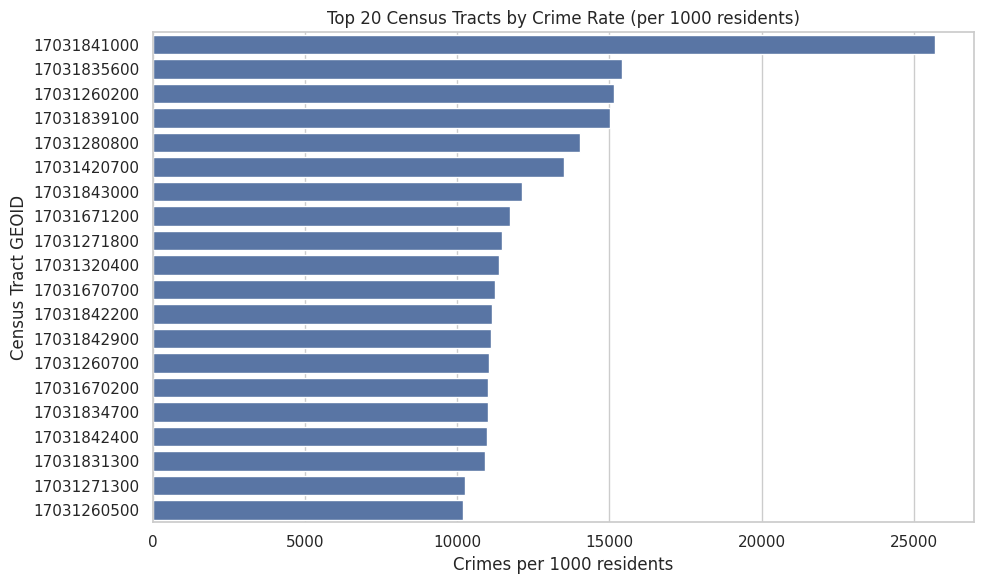

In [ ]:
# Analyze crime rates by census tract (normalized by population)
import seaborn as sns

sns.set(style="whitegrid")  # Set seaborn style for clean plots

# Calculate crime rate per 1,000 residents for each tract
crime_rates_by_tract = spark.sql("""
    SELECT
        tract_geoid,
        COUNT(*) AS total_crimes,
        MAX(population) AS population_estimate,
        COUNT(*) / MAX(population) * 1000.0 AS crimes_per_1000
    FROM crime_weather_demo
    WHERE population IS NOT NULL  -- Only tracts with population data
    GROUP BY tract_geoid
""")

# Register as temp view for subsequent queries
crime_rates_by_tract.createOrReplaceTempView("crime_rates_by_tract")

# Get top 20 tracts by crime rate
top_tracts_pdf = spark.sql("""
    SELECT *
    FROM crime_rates_by_tract
    ORDER BY crimes_per_1000 DESC
    LIMIT 20
""").toPandas()

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_tracts_pdf,
    x="crimes_per_1000",
    y="tract_geoid"
)
plt.xlabel("Crimes per 1000 residents")
plt.ylabel("Census Tract GEOID")
plt.title("Top 20 Census Tracts by Crime Rate (per 1000 residents)")
plt.tight_layout()
plt.show()


## Step 16: Temperature Impact Analysis

This cell examines the relationship between temperature and crime frequency:

- **Temperature Bucketing**: Groups crimes into temperature ranges (<0°C, 0-10°C, 10-20°C, 20-30°C, ≥30°C)
- **Crime Frequency by Temperature**: Counts total crimes in each temperature bucket
- **Visualization**: Bar chart showing crime distribution across temperature ranges

This analysis helps identify whether temperature extremes (very hot or very cold) correlate with crime patterns, potentially revealing seasonal behavioral patterns.


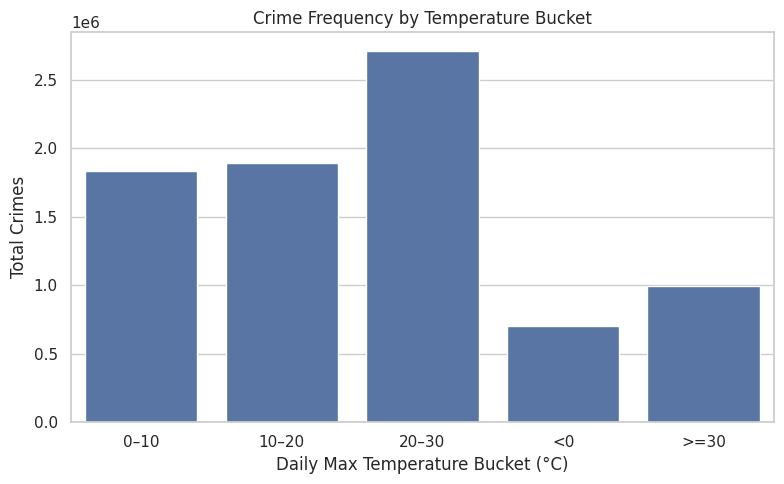

In [ ]:
# Analyze crime frequency by temperature ranges
temp_buckets = spark.sql("""
    SELECT
        CASE
            WHEN TMAX_avg < 0 THEN '<0'
            WHEN TMAX_avg >= 0 AND TMAX_avg < 10 THEN '0–10'
            WHEN TMAX_avg >= 10 AND TMAX_avg < 20 THEN '10–20'
            WHEN TMAX_avg >= 20 AND TMAX_avg < 30 THEN '20–30'
            ELSE '>=30'
        END AS temp_bucket,
        COUNT(*) AS total_crimes
    FROM crime_weather_demo
    WHERE TMAX_avg IS NOT NULL  -- Only records with temperature data
    GROUP BY
        CASE
            WHEN TMAX_avg < 0 THEN '<0'
            WHEN TMAX_avg >= 0 AND TMAX_avg < 10 THEN '0–10'
            WHEN TMAX_avg >= 10 AND TMAX_avg < 20 THEN '10–20'
            WHEN TMAX_avg >= 20 AND TMAX_avg < 30 THEN '20–30'
            ELSE '>=30'
        END
    ORDER BY temp_bucket
""")

# Register temp view and convert to Pandas for visualization
temp_buckets.createOrReplaceTempView("temp_buckets")
temp_buckets_pdf = temp_buckets.toPandas()

# Create bar chart showing crime frequency by temperature range
plt.figure(figsize=(8, 5))
sns.barplot(
    data=temp_buckets_pdf,
    x="temp_bucket",
    y="total_crimes"
)
plt.xlabel("Daily Max Temperature Bucket (°C)")
plt.ylabel("Total Crimes")
plt.title("Crime Frequency by Temperature Bucket")
plt.tight_layout()
plt.show()


## Step 17: Precipitation Impact Analysis

This cell compares crime frequency on rainy versus dry days:

- **Weather Classification**: Categorizes days as "Rainy" (precipitation > 0) or "Dry" (precipitation = 0)
- **Aggregation**: Counts total crimes for each weather category
- **Visualization**: Bar chart comparing crime volumes between rainy and dry conditions

This analysis tests the hypothesis that weather conditions (specifically precipitation) may influence crime patterns, potentially affecting outdoor activities and social interactions.


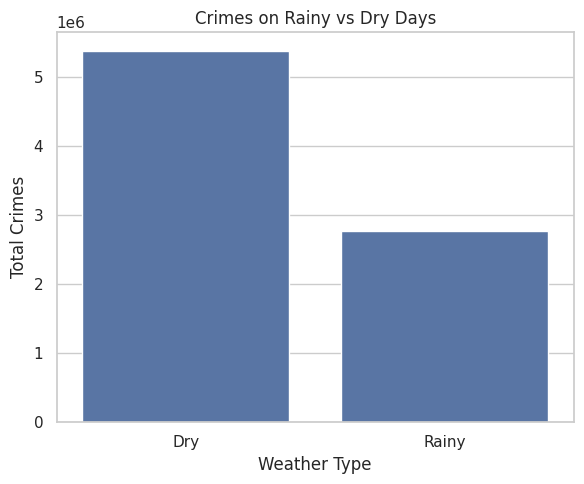

In [ ]:
# Compare crime frequency on rainy vs dry days
rain_vs_dry = spark.sql("""
    SELECT
        CASE WHEN PRCP_avg > 0 THEN 'Rainy' ELSE 'Dry' END AS precip_type,
        COUNT(*) AS total_crimes
    FROM crime_weather_demo
    WHERE PRCP_avg IS NOT NULL  -- Only records with precipitation data
    GROUP BY
        CASE WHEN PRCP_avg > 0 THEN 'Rainy' ELSE 'Dry' END
""")

# Register temp view and convert to Pandas
rain_vs_dry.createOrReplaceTempView("rain_vs_dry")
rain_vs_dry_pdf = rain_vs_dry.toPandas()

# Create comparison bar chart
plt.figure(figsize=(6, 5))
sns.barplot(
    data=rain_vs_dry_pdf,
    x="precip_type",
    y="total_crimes"
)
plt.xlabel("Weather Type")
plt.ylabel("Total Crimes")
plt.title("Crimes on Rainy vs Dry Days")
plt.tight_layout()
plt.show()


## Step 18: Precipitation Impact by Crime Type

This cell extends the precipitation analysis by examining how different crime types are affected by weather:

- **Crime Type Breakdown**: Analyzes precipitation impact separately for each crime type
- **Top Types Focus**: Limits visualization to top 10 most frequent crime types for readability
- **Grouped Comparison**: Side-by-side bars showing rainy vs dry day crime counts per type
- **Pattern Identification**: Reveals which crime types are more sensitive to weather conditions

This granular analysis helps identify which specific crimes are most influenced by precipitation, providing insights for weather-based crime prediction models.


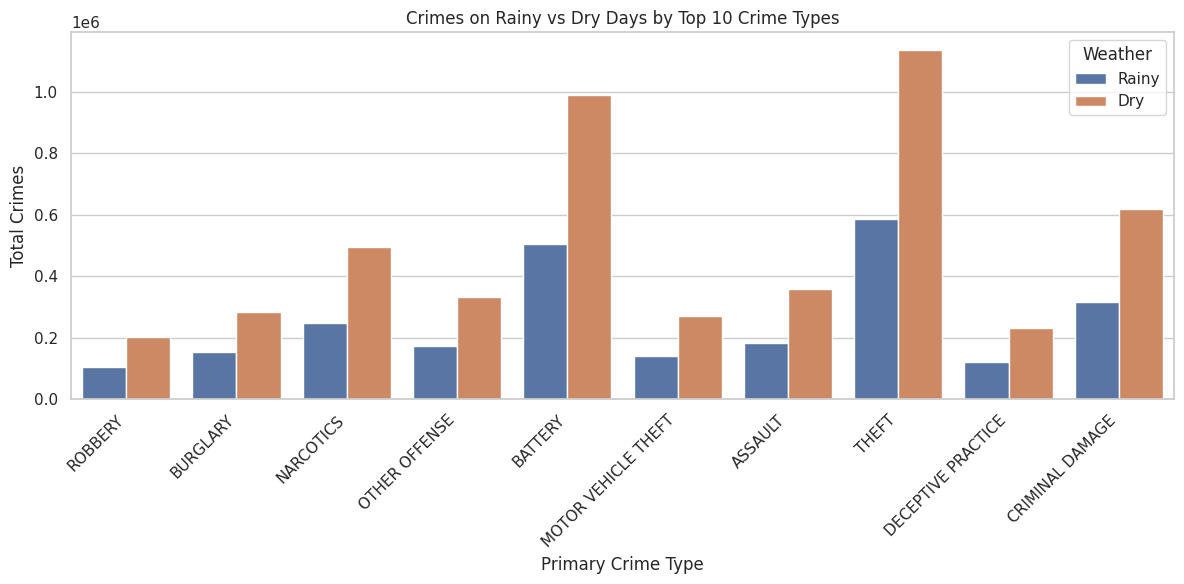

In [ ]:
# Analyze precipitation impact by crime type
rain_vs_dry_by_type = spark.sql("""
    SELECT
        primary_type,
        CASE WHEN PRCP_avg > 0 THEN 'Rainy' ELSE 'Dry' END AS precip_type,
        COUNT(*) AS total_crimes
    FROM crime_weather_demo
    WHERE PRCP_avg IS NOT NULL  -- Only records with precipitation data
    GROUP BY primary_type,
             CASE WHEN PRCP_avg > 0 THEN 'Rainy' ELSE 'Dry' END
""")

# Register temp view and convert to Pandas
rain_vs_dry_by_type.createOrReplaceTempView("rain_vs_dry_by_type")
rain_vs_dry_by_type_pdf = rain_vs_dry_by_type.toPandas()

# Filter to top 10 crime types for readability
# Calculate total crimes per type and select most frequent
top_types = (
    rain_vs_dry_by_type_pdf.groupby("primary_type")["total_crimes"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
plot_data = rain_vs_dry_by_type_pdf[
    rain_vs_dry_by_type_pdf["primary_type"].isin(top_types)
]

# Create grouped bar chart comparing rainy vs dry days by crime type
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data,
    x="primary_type",
    y="total_crimes",
    hue="precip_type"  # Grouped by weather condition
)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.xlabel("Primary Crime Type")
plt.ylabel("Total Crimes")
plt.title("Crimes on Rainy vs Dry Days by Top 10 Crime Types")
plt.legend(title="Weather")
plt.tight_layout()
plt.show()


## Step 19: Temperature and Crime Correlation Over Time

This cell creates a dual-axis time series plot showing the relationship between temperature and crime over time:

- **Dual Y-Axes**:
  - Left axis: Daily crime count
  - Right axis: Average maximum temperature
- **Temporal Correlation**: Visualizes how crime patterns align with temperature trends across the entire dataset
- **Time Series Analysis**: Helps identify seasonal patterns and long-term correlations between weather and crime

This visualization enables identification of seasonal crime patterns and potential temperature-crime relationships over extended time periods.


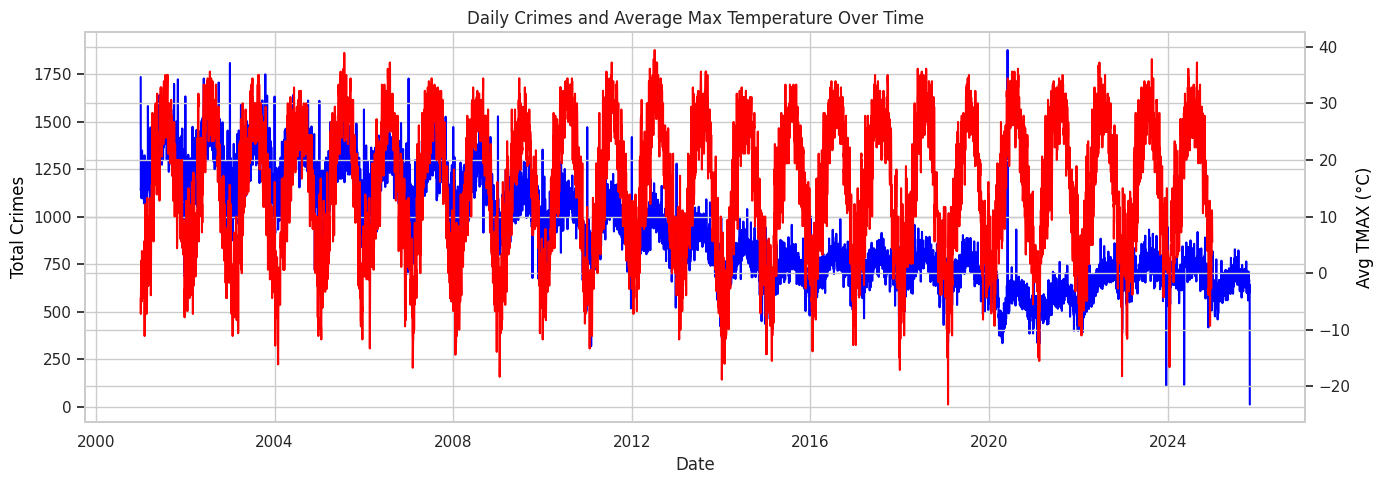

In [ ]:
# Create dual-axis time series plot: crimes and temperature over time
daily_temp_trend = spark.sql("""
    SELECT
        crime_date,
        COUNT(*) AS total_crimes,
        AVG(TMAX_avg) AS avg_TMAX
    FROM crime_weather_demo
    WHERE crime_date IS NOT NULL
    GROUP BY crime_date
    ORDER BY crime_date
""")

# Register temp view and convert to Pandas
daily_temp_trend.createOrReplaceTempView("daily_temp_trend")
daily_temp_pdf = daily_temp_trend.toPandas().sort_values("crime_date")

# Create figure with dual y-axes for crime count and temperature
fig, ax1 = plt.subplots(figsize=(14, 5))

# Left y-axis: Daily crime count
ax1.plot(daily_temp_pdf["crime_date"], daily_temp_pdf["total_crimes"], color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Crimes", color="black")

# Right y-axis: Average maximum temperature
ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis
ax2.plot(daily_temp_pdf["crime_date"], daily_temp_pdf["avg_TMAX"], color='red')
ax2.set_ylabel("Avg TMAX (°C)", color="black")

plt.title("Daily Crimes and Average Max Temperature Over Time")
fig.tight_layout()
plt.show()


## Step 20: Interactive Geospatial Map - High Crime Rate Tracts

This cell creates an interactive Folium map showing the top 20 census tracts by crime rate:

- **Tract Selection**: Identifies top 20 tracts with highest crimes per 1,000 residents
- **Shapefile Integration**: Loads census tract boundaries from TIGER/Line shapefiles using GeoPandas
- **GEOID Matching**: Matches crime rate data with tract geometries using standardized GEOID
- **Interactive Features**:
  - Hover tooltips showing tract GEOID and crime rate
  - Color-coded polygons (red) highlighting high-crime areas
  - Zoom and pan capabilities for detailed exploration

This visualization provides geographic context for crime hotspots, enabling spatial analysis and resource allocation planning.


In [ ]:
# Create interactive map of top 20 high-crime rate census tracts
import geopandas as gpd

# Get top 20 tracts by crime rate from Spark SQL
top_tracts_pdf = spark.sql("""
    SELECT tract_geoid,
           crimes_per_1000
    FROM crime_rates_by_tract
    ORDER BY crimes_per_1000 DESC
    LIMIT 20
""").toPandas()

# Load census tract shapefiles using GeoPandas
shapefile_path = "/content/drive/MyDrive/Census_Tracts"  # Folder containing .shp files
tracts_gdf = gpd.read_file(shapefile_path)
print(tracts_gdf.columns)

# Standardize GEOID column name to match crime data
if "GEOID" in tracts_gdf.columns:
    tracts_gdf["tract_geoid"] = tracts_gdf["GEOID"]
elif "GEOID10" in tracts_gdf.columns:
    tracts_gdf["tract_geoid"] = tracts_gdf["GEOID10"]
else:
    # Construct GEOID from component fields if not present
    tracts_gdf["tract_geoid"] = (
        tracts_gdf["STATEFP"] + tracts_gdf["COUNTYFP"] + tracts_gdf["TRACTCE"]
    )

# Merge crime rate data with tract geometries
top20_map_gdf = tracts_gdf.merge(
    top_tracts_pdf,
    how="inner",
    on="tract_geoid"
)

# Create interactive Folium map centered on Chicago
import folium
from folium.features import GeoJsonTooltip

# Center map on Chicago coordinates
m = folium.Map(location=[41.85, -87.65], zoom_start=10)

# Add tract polygons with styling and tooltips
folium.GeoJson(
    top20_map_gdf,
    style_function=lambda x: {
        "fillColor": "red",  # Red color for high-crime tracts
        "color": "black",  # Black border
        "weight": 1,
        "fillOpacity": 0.6,  # Semi-transparent fill
    },
    tooltip=GeoJsonTooltip(
        fields=["tract_geoid", "crimes_per_1000"],
        aliases=["Tract GEOID", "Crimes per 1000"],
        localize=True
    )
).add_to(m)

m

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')


## Step 21: Static Map Visualization - High Crime Rate Tracts

This cell creates a static matplotlib visualization of high-crime census tracts:

- **Base Map**: Displays all Chicago census tracts in light gray for geographic context
- **Highlighted Tracts**: Overlays top 20 high-crime rate tracts with color gradient (red scale)
- **Color Mapping**: Uses "Reds" colormap to show crime rate intensity
- **Legend**: Includes color scale legend showing crimes per 1,000 residents
- **Static Output**: Suitable for reports and presentations

This visualization provides a clear, publication-ready view of crime hotspots while maintaining geographic context of the entire city.


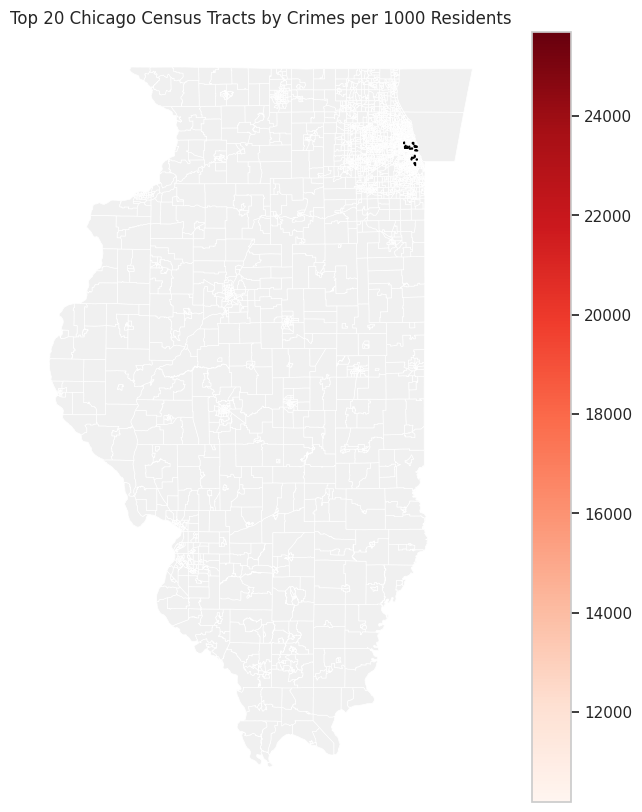

In [ ]:
# Create static map visualization of high-crime rate tracts
import matplotlib.pyplot as plt

# Create figure for map visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all Chicago census tracts as base map (light gray background)
tracts_gdf.plot(ax=ax, color="#f0f0f0", edgecolor="white", linewidth=0.5)

# Overlay top 20 high-crime tracts with color gradient
# Color intensity represents crime rate (darker red = higher rate)
top20_map_gdf.plot(
    ax=ax,
    column="crimes_per_1000",  # Column to color by
    cmap="Reds",  # Red color scale
    edgecolor="black",  # Black borders for visibility
    linewidth=1,
    legend=True  # Show color scale legend
)

plt.title("Top 20 Chicago Census Tracts by Crimes per 1000 Residents")
plt.axis("off")  # Remove axes for cleaner map appearance
plt.show()


## Notes and next steps

- If shapefile lacks GEOID, construct via STATEFP+COUNTYFP+TRACTCE and ensure ACS GEO_ID extraction matches.
- For large-scale runs, increase `spark.sql.shuffle.partitions` and move storage to HDFS/S3/GS.
- Add census enrichment for additional variables (education, unemployment) by reading corresponding ACS tables and joining on GEO_ID.
- Consider caching intermediate DataFrames for performance.